In [38]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [39]:
%run utils.ipynb

In [40]:
data = pd.read_parquet(processed_dataset_path)
train_categorical_columns = ['course', 'gender', 'pre_existing_medical_condition']
for col in train_categorical_columns:
    data[col] = data[col].astype('category')

X = data.drop('unsuccessful_outcome', axis=1)
y = data['unsuccessful_outcome'].astype(int)

In [41]:
# Splitting the dataset into train, validation, and test sets (60%, 20%, 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [42]:
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    cat_features=train_categorical_columns
)

# Fit model
catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# Predict on the validation set
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for validation set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')


0:	test: 0.9228701	best: 0.9228701 (0)	total: 55.5ms	remaining: 55.4s
100:	test: 0.9632212	best: 0.9636566 (80)	total: 4.93s	remaining: 43.9s
200:	test: 0.9622342	best: 0.9636566 (80)	total: 10s	remaining: 39.8s
300:	test: 0.9604609	best: 0.9636566 (80)	total: 15.8s	remaining: 36.8s
400:	test: 0.9600622	best: 0.9636566 (80)	total: 22.2s	remaining: 33.1s
500:	test: 0.9591499	best: 0.9636566 (80)	total: 28.2s	remaining: 28.1s
600:	test: 0.9593162	best: 0.9636566 (80)	total: 34s	remaining: 22.6s
700:	test: 0.9588955	best: 0.9636566 (80)	total: 39.6s	remaining: 16.9s
800:	test: 0.9585482	best: 0.9636566 (80)	total: 45.1s	remaining: 11.2s
900:	test: 0.9584993	best: 0.9636566 (80)	total: 50.6s	remaining: 5.56s
999:	test: 0.9576334	best: 0.9636566 (80)	total: 56.2s	remaining: 0us

bestTest = 0.9636565762
bestIteration = 80

Shrink model to first 81 iterations.
Accuracy: 0.9173
Precision: 0.7759
Recall: 0.9052
F1 Score: 0.8355
ROC-AUC Score: 0.9607


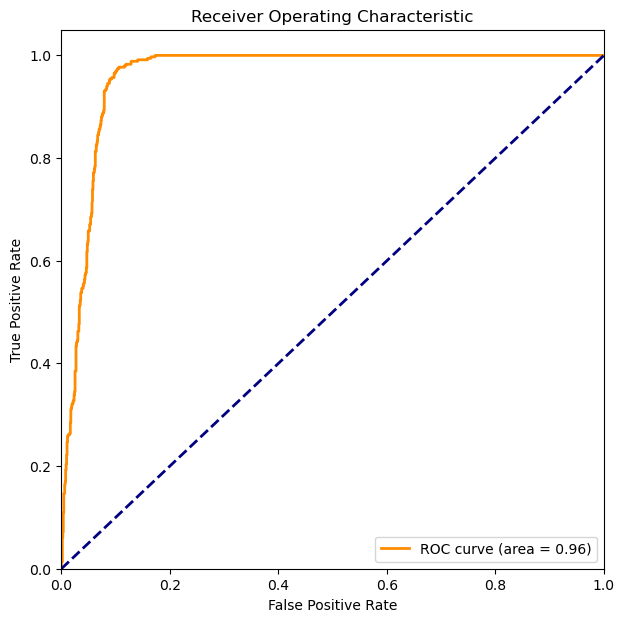

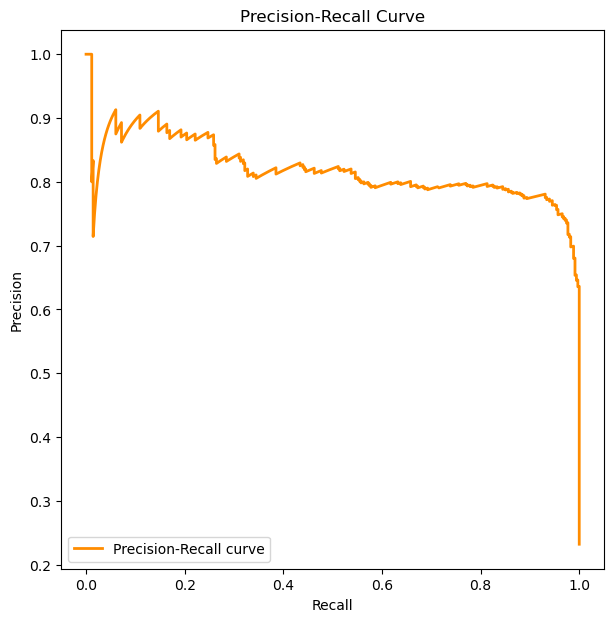

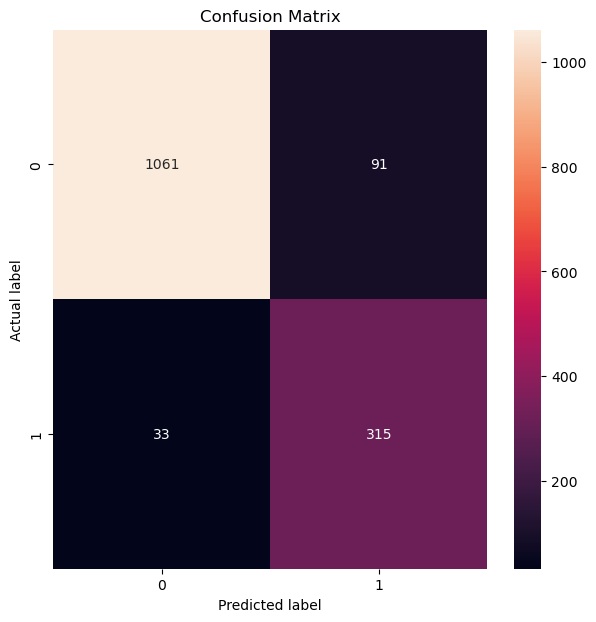

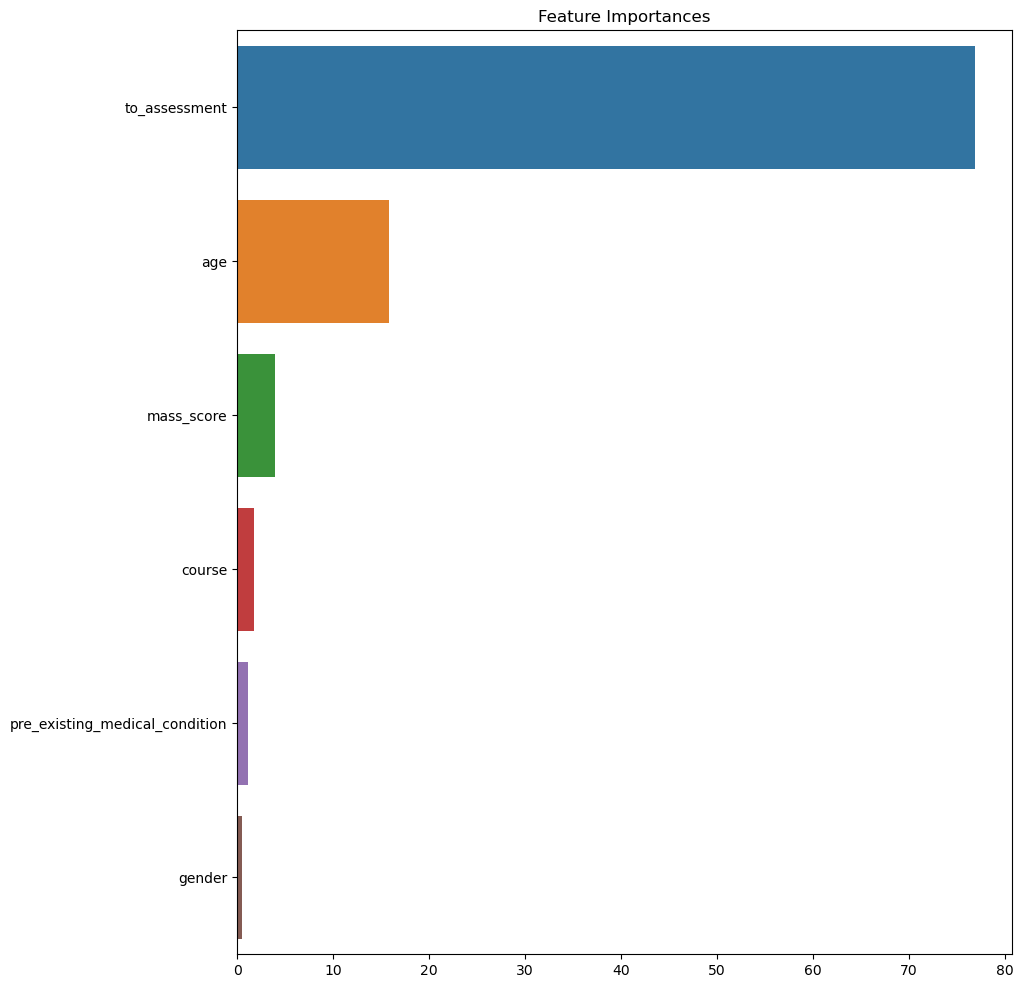

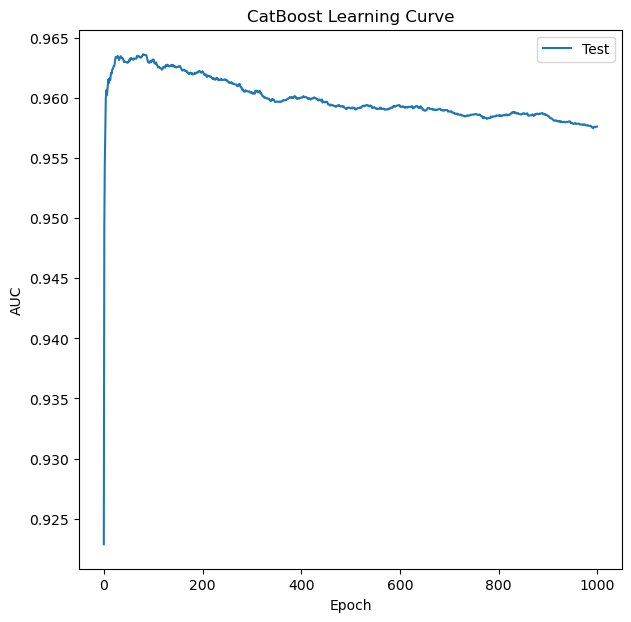

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 7))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Feature Importance
feature_importances = catboost_model.get_feature_importance()
sorted_indices = feature_importances.argsort()[::-1]
plt.figure(figsize=(10, 12))
plt.title("Feature Importances")
sns.barplot(y=X_train.columns[sorted_indices], x=feature_importances[sorted_indices])
plt.show()

# Learning Curve (if you have stored the evaluation results during training)
results = catboost_model.get_evals_result()
epochs = len(results['validation']['AUC'])
x_axis = range(0, epochs)
plt.figure(figsize=(7, 7))
plt.plot(x_axis, results['validation']['AUC'], label='Test')
plt.title('CatBoost Learning Curve')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()
